In [1]:
!python -V

Python 3.12.7


In [2]:
import pandas as pd

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [53]:
import pickle

In [55]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [3]:
green_jan_2021 = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

In [4]:
green_jan_2021['duration'] = green_jan_2021.lpep_dropoff_datetime - green_jan_2021.lpep_pickup_datetime
green_jan_2021.duration = green_jan_2021.duration.apply(lambda td: td.total_seconds() / 60)

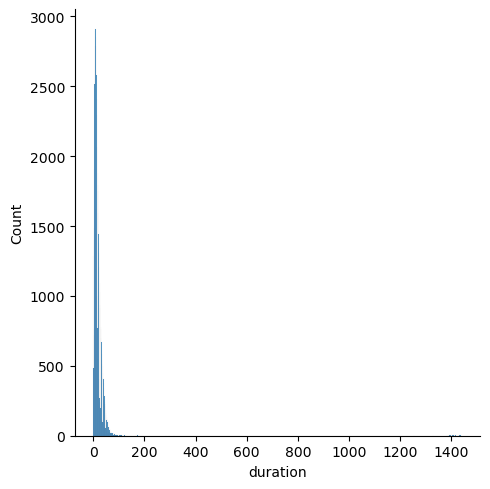

In [7]:
sns.displot(green_jan_2021.duration)

In [8]:
green_jan_2021.duration.describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

In [9]:
((green_jan_2021.duration >= 1) & (green_jan_2021.duration <= 60)).mean()

0.9658903787344154

In [10]:
green_jan_2021.shape

(76518, 21)

In [11]:
green_jan_2021 = green_jan_2021[(green_jan_2021.duration >= 1) & (green_jan_2021.duration <= 60)]

In [12]:
green_jan_2021.shape

(73908, 21)

In [14]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [15]:
green_jan_2021[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [16]:
green_jan_2021[categorical] = green_jan_2021[categorical].astype(str)

In [17]:
green_jan_2021[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [19]:
green_jan_2021[categorical + numerical].iloc[:10]

,PULocationID,DOLocationID,trip_distance
0,43,151,1.01
1,166,239,2.53
2,41,42,1.12
3,168,75,1.99
7,75,75,0.45
9,225,265,12.19
10,244,244,3.39
11,75,213,6.69
12,74,238,2.34
13,74,60,5.48


In [21]:
green_jan_2021[categorical + numerical].iloc[:10].to_dict(orient='records')

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '75', 'DOLocationID': '75', 'trip_distance': 0.45},
 {'PULocationID': '225', 'DOLocationID': '265', 'trip_distance': 12.19},
 {'PULocationID': '244', 'DOLocationID': '244', 'trip_distance': 3.39},
 {'PULocationID': '75', 'DOLocationID': '213', 'trip_distance': 6.69},
 {'PULocationID': '74', 'DOLocationID': '238', 'trip_distance': 2.34},
 {'PULocationID': '74', 'DOLocationID': '60', 'trip_distance': 5.48}]

In [29]:
train_dicts = green_jan_2021[categorical + numerical].to_dict(orient='records')

In [30]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [31]:
X_train.shape

(73908, 507)

In [32]:
target = 'duration'
y_train = green_jan_2021[target].values

In [33]:
y_train.shape

(73908,)

In [34]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [35]:
y_pred = lr.predict(X_train)

/tmp/ipykernel_2255/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_2255/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


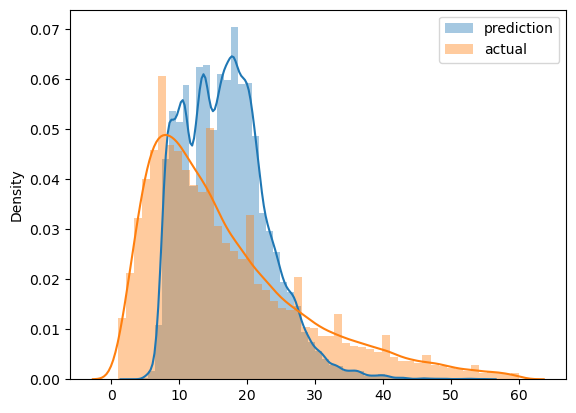

In [37]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [39]:
root_mean_squared_error(y_train, y_pred)

9.838799799886681

In [40]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

In [42]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [43]:
len(df_train), len(df_val)

(73908, 61921)

In [44]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_'  + df_val['DOLocationID']

In [49]:
categorical = ['PU_DO'] #['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [50]:
dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [51]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [52]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
root_mean_squared_error(y_val, y_pred)

7.758715206128955

In [54]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [56]:
lr_lasso = Lasso(0.01)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
root_mean_squared_error(y_val, y_pred)

7.758715206128955

In [57]:
lr_ridge = Ridge(0.01)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
root_mean_squared_error(y_val, y_pred)

7.758715206128955